# Import Tools

In [1]:
!pip install -q catboost xgboost

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report
import joblib

# Get the data

In [3]:
df = pd.read_csv("YearProject2_-_Sheet2.csv")
df.head()

,long sleeve top,short sleeve top,long sleeve outwear,short sleeve outwear,shorts,skirt,trousers,local_temp,local_humid,comfort_level
0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,35,52,2
1,NaN,1.0,NaN,NaN,NaN,NaN,1.0,35,52,1
2,1.0,NaN,NaN,NaN,NaN,NaN,1.0,35,51,1
3,NaN,1.0,NaN,NaN,NaN,NaN,1.0,24,51,4
4,NaN,NaN,NaN,1.0,NaN,NaN,1.0,24,50,4


# EDA / Data Preprocessing

## Handle Missing Values

In [4]:
df = df.fillna(0)
df.head()

,long sleeve top,short sleeve top,long sleeve outwear,short sleeve outwear,shorts,skirt,trousers,local_temp,local_humid,comfort_level
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,35,52,2
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,35,52,1
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,35,51,1
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,24,51,4
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,24,50,4


## Handle Outlier

In [5]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print("Before remove outlier: ", df.shape)
df = df[((df >= lower_bound) | (df <= upper_bound)).any(axis=1)]
print("After remove outlier: ", df.shape)

Before remove outlier:  (79, 10)
After remove outlier:  (79, 10)


## Handle Distribution

### Show the distribution

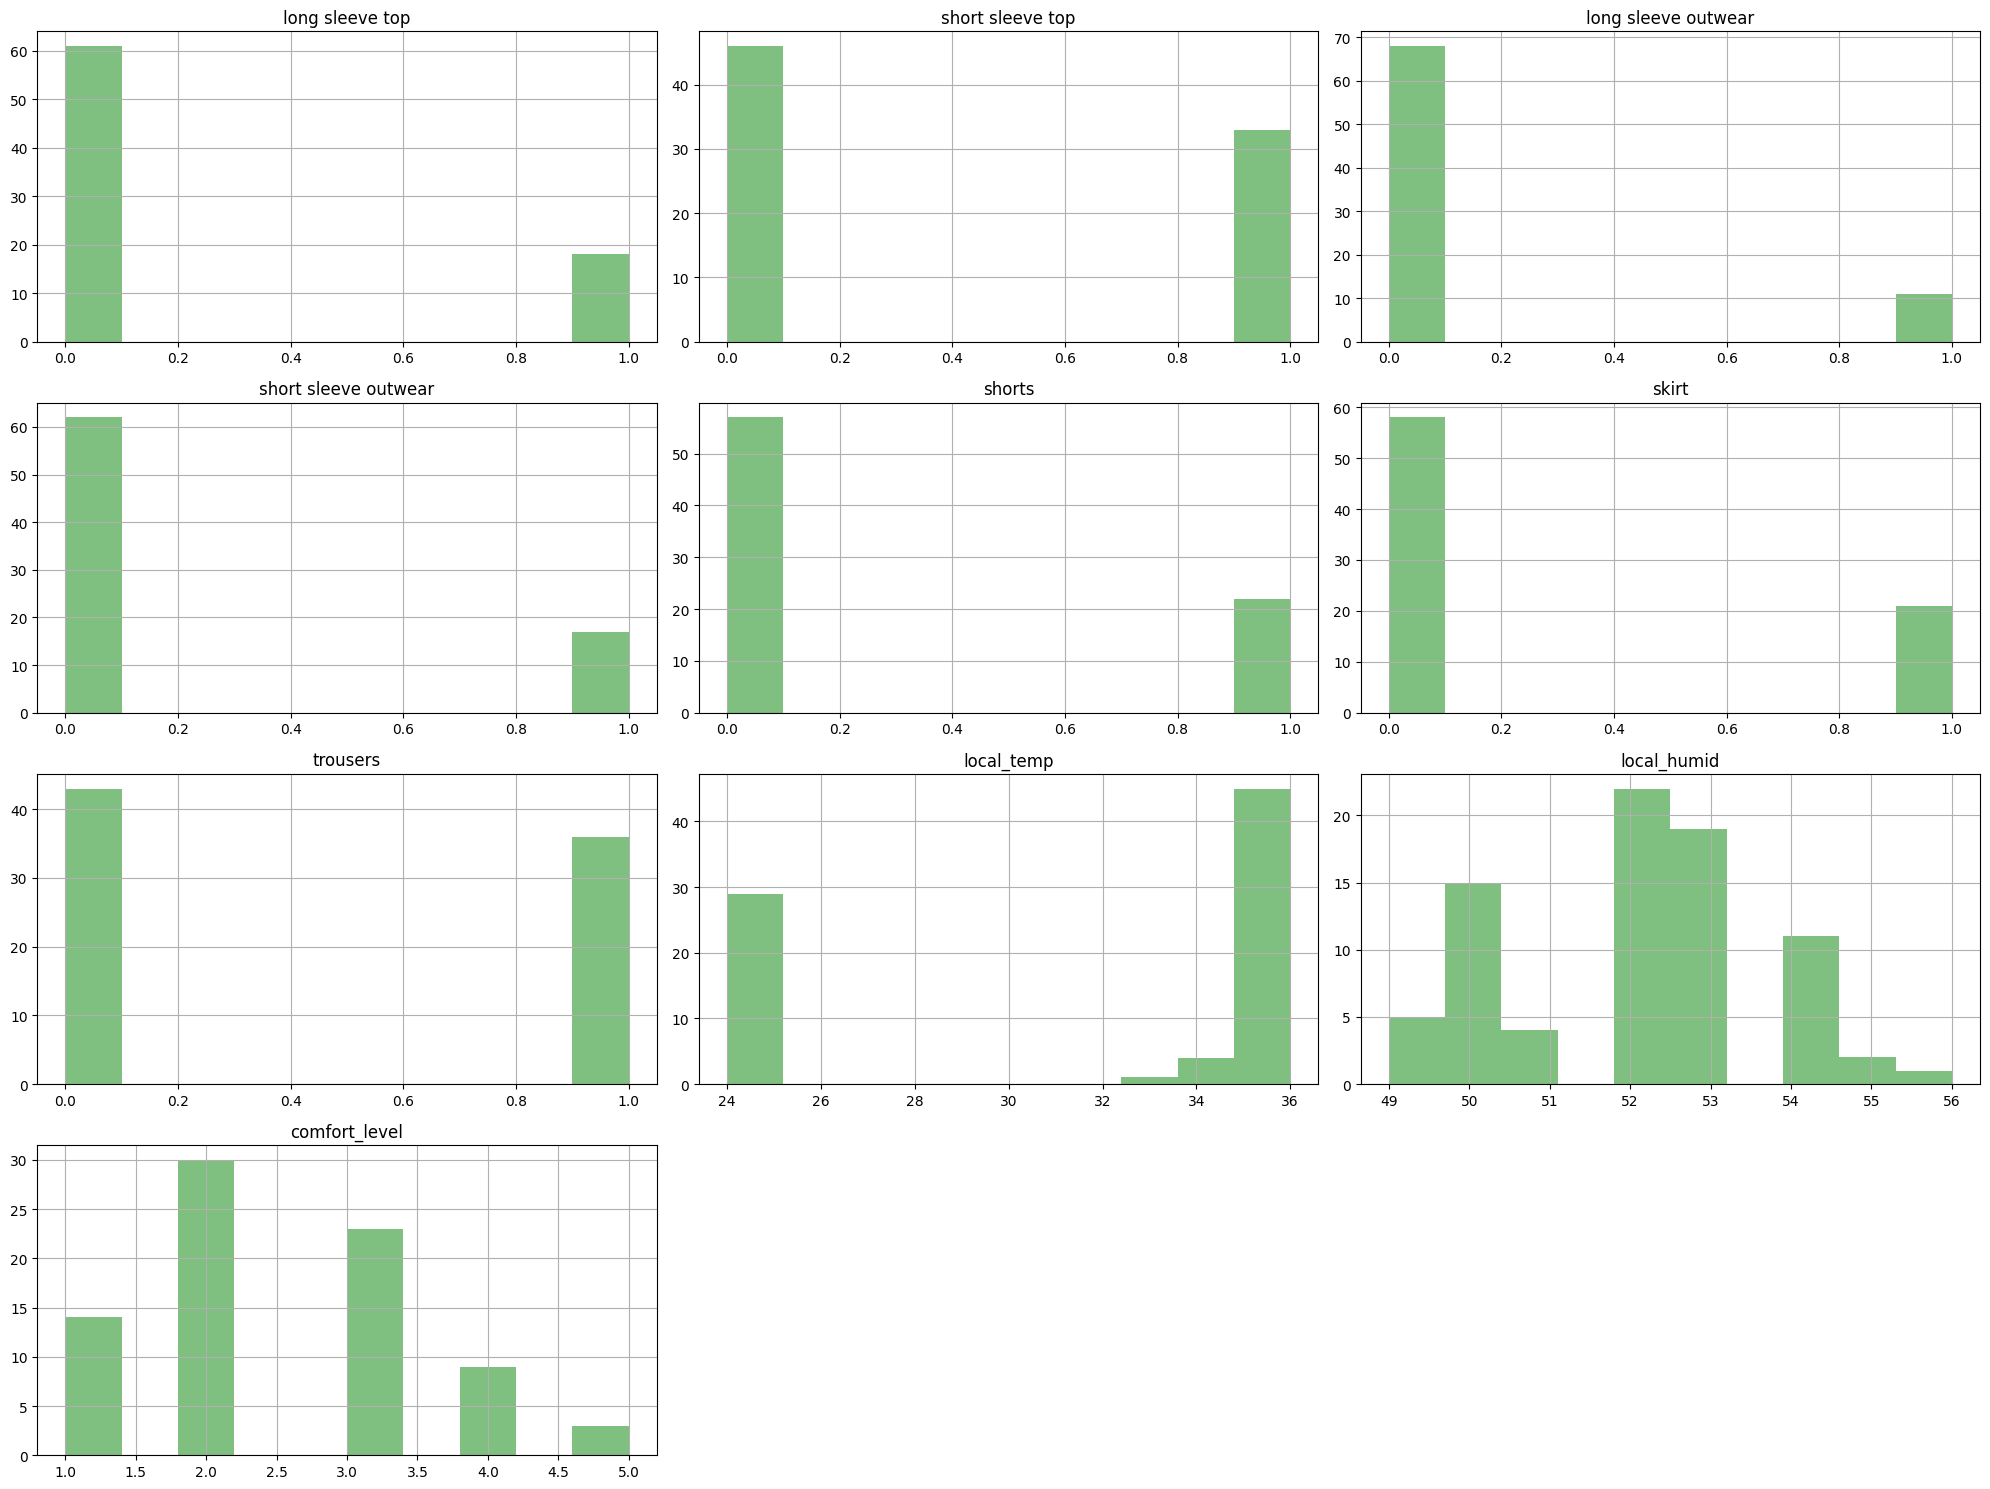

In [6]:
df.hist(figsize=(20, 15), color="green", alpha=0.5)
plt.tight_layout()
plt.show()

In [7]:
print("Skewness features:")
for feature in df.columns:
    if abs(df[feature].skew()) > 1:
        print(f"- {feature}")

Skewness features:
- long sleeve top
- long sleeve outwear
- short sleeve outwear
- shorts
- skirt


## Split input and output

In [8]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1:]
X.shape, y.shape

((79, 9), (79, 1))

## Normalization (z-score)

In [9]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X[0]

array([-0.54321448,  1.18065211, -0.40219983, -0.52363494, -0.62126074,
       -0.60172167,  1.09290642,  0.73716278, -0.01567964])

## Handle classes imbalance

In [10]:
df.iloc[:, :4].sum()

long sleeve top         18.0
short sleeve top        33.0
long sleeve outwear     11.0
short sleeve outwear    17.0
dtype: float64

In [11]:
print("Upper classes (%): ")
print(df.iloc[:, :4].sum() / df.iloc[:, :4].sum().sum())
print()
print("Lower classes (%): ")
print(df.iloc[:, 4:7].sum() / df.iloc[:, 4:7].sum().sum())

Upper classes (%): 
long sleeve top         0.227848
short sleeve top        0.417722
long sleeve outwear     0.139241
short sleeve outwear    0.215190
dtype: float64

Lower classes (%): 
shorts      0.278481
skirt       0.265823
trousers    0.455696
dtype: float64


### Under-sampling

In [12]:
undersample = NearMiss(version=3, n_neighbors_ver3=2)
X_under, y_under = undersample.fit_resample(X, y)

### Over-sampling

In [13]:
X_over, y_over = SMOTE(k_neighbors=2).fit_resample(X, y)

## Split training/testing data

### Non-imbalance handle data

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((63, 9), (16, 9), (63, 1), (16, 1))

### Under-sampling data

In [15]:
X_under_train, X_under_test, y_under_train, y_under_test = train_test_split(X_under, y_under, test_size=0.2, random_state=42)
X_under_train.shape, X_under_test.shape, y_under_train.shape, y_under_test.shape

((12, 9), (3, 9), (12, 1), (3, 1))

### Over-sampling data

In [16]:
X_over_train, X_over_test, y_over_train, y_over_test = train_test_split(X_over, y_over, test_size=0.2, random_state=42)
X_over_train.shape, X_over_test.shape, y_over_train.shape, y_over_test.shape

((120, 9), (30, 9), (120, 1), (30, 1))

# Model

In [17]:
models = [
    ('RandomForest', RandomForestClassifier(max_depth=2, random_state=0)),
    ('KNN', KNeighborsClassifier()),
    ('Naive Bayes', GaussianNB()),
    ('LightGBM', LGBMClassifier(random_state=0)),
    ('GradientBoosting', GradientBoostingClassifier(random_state=0)),
    ('VotingClassifier', VotingClassifier(estimators=[
        ('RandomForest', RandomForestClassifier(max_depth=2, random_state=0)),
        ('KNN', KNeighborsClassifier()),
        ('SVM', SVC(probability=True))
    ])),
    ('BaggingClassifier', BaggingClassifier(base_estimator=RandomForestClassifier(max_depth=2), n_estimators=10, random_state=0)),
    ('AdaBoost', AdaBoostClassifier(random_state=0)),
    ('MLP', MLPClassifier(random_state=0))
]

datasets = [
    ('Original', X_train, X_test, y_train, y_test),
    ('Undersampled', X_under_train, X_under_test, y_under_train, y_under_test),
    ('Oversampled', X_over_train, X_over_test, y_over_train, y_over_test)
]

all_results = []
for dataset_name, X_train, X_test, y_train, y_test in datasets:
    print(f"Dataset: {dataset_name}")
    model_results = []
    for model_name, model in models:
        print(f"Model: {model_name}")
        scores = cross_val_score(model, X_train, y_train["comfort_level"], cv=3, scoring='f1_micro')
        print(f"Cross-validation scores: {scores}")
        print(f"Mean cross-validation score: {scores.mean()}")
        model_results.append(scores.mean())
        
        y_pred = cross_val_predict(model, X_train, y_train["comfort_level"], cv=3)
        conf_mat = confusion_matrix(y_train, y_pred)

        print("Confusion Matrix:")
        print(conf_mat)

        print("Classification Report:")
        print(classification_report(y_train, y_pred, zero_division=1))
        
        print()
    all_results.append(model_results)
    print()

Dataset: Original
Model: RandomForest
Cross-validation scores: [0.57142857 0.66666667 0.47619048]
Mean cross-validation score: 0.5714285714285715
Confusion Matrix:
[[ 2  7  1  0  0]
 [ 3 18  2  0  0]
 [ 0  5 15  0  1]
 [ 0  0  5  1  0]
 [ 0  0  3  0  0]]
Classification Report:
              precision    recall  f1-score   support

           1       0.40      0.20      0.27        10
           2       0.60      0.78      0.68        23
           3       0.58      0.71      0.64        21
           4       1.00      0.17      0.29         6
           5       0.00      0.00      1.00         3

    accuracy                           0.57        63
   macro avg       0.52      0.37      0.57        63
weighted avg       0.57      0.57      0.58        63


Model: KNN
Cross-validation scores: [0.71428571 0.66666667 0.47619048]
Mean cross-validation score: 0.6190476190476191
Confusion Matrix:
[[ 6  4  0  0  0]
 [ 4 15  4  0  0]
 [ 0  4 16  0  1]
 [ 0  0  4  2  0]
 [ 1  0  2  0  0]]
Clas

C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Cross-validation scores: [0.66666667 0.71428571 0.52380952]
Mean cross-validation score: 0.6349206349206349


C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Confusion Matrix:
[[ 5  5  0  0  0]
 [ 2 19  2  0  0]
 [ 0  5 16  0  0]
 [ 0  0  6  0  0]
 [ 0  0  3  0  0]]
Classification Report:
              precision    recall  f1-score   support

           1       0.71      0.50      0.59        10
           2       0.66      0.83      0.73        23
           3       0.59      0.76      0.67        21
           4       1.00      0.00      0.00         6
           5       1.00      0.00      0.00         3

    accuracy                           0.63        63
   macro avg       0.79      0.42      0.40        63
weighted avg       0.69      0.63      0.58        63


Model: AdaBoost
Cross-validation scores: [0.52380952 0.38095238 0.47619048]
Mean cross-validation score: 0.4603174603174603
Confusion Matrix:
[[ 0  6  4  0  0]
 [ 0 15  8  0  0]
 [ 0  5 14  0  2]
 [ 0  0  6  0  0]
 [ 0  0  3  0  0]]
Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.00      0.00        10
           2 

C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Cross-validation scores: [0.71428571 0.61904762 0.61904762]
Mean cross-validation score: 0.6507936507936508
Confusion Matrix:
[[ 5  5  0  0  0]
 [ 3 17  3  0  0]
 [ 0  1 16  3  1]
 [ 0  0  2  3  1]
 [ 0  0  3  0  0]]
Classification Report:


C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


              precision    recall  f1-score   support

           1       0.62      0.50      0.56        10
           2       0.74      0.74      0.74        23
           3       0.67      0.76      0.71        21
           4       0.50      0.50      0.50         6
           5       0.00      0.00      1.00         3

    accuracy                           0.65        63
   macro avg       0.51      0.50      0.70        63
weighted avg       0.64      0.65      0.69        63



Dataset: Undersampled
Model: RandomForest
Cross-validation scores: [0.5  0.25 0.25]
Mean cross-validation score: 0.3333333333333333


C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Confusion Matrix:
[[0 1 0 0 1]
 [2 1 0 0 0]
 [0 0 1 0 2]
 [0 0 1 0 0]
 [0 0 1 0 2]]
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      1.00         2
           2       0.50      0.33      0.40         3
           3       0.33      0.33      0.33         3
           4       1.00      0.00      0.00         1
           5       0.40      0.67      0.50         3

    accuracy                           0.33        12
   macro avg       0.45      0.27      0.45        12
weighted avg       0.39      0.33      0.48        12


Model: KNN
Cross-validation scores: [0.25 0.   0.25]
Mean cross-validation score: 0.16666666666666666
Confusion Matrix:
[[0 1 0 0 1]
 [1 0 0 0 2]
 [0 1 1 0 1]
 [0 0 1 0 0]
 [1 0 1 0 1]]
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      1.00         2
           2       0.00      0.00      1.00         3
           3       0.33      0.

C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  

Cross-validation scores: [0.5  0.5  0.25]
Mean cross-validation score: 0.4166666666666667


C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Confusion Matrix:
[[1 1 0 0 0]
 [2 1 0 0 0]
 [0 0 1 0 2]
 [0 0 1 0 0]
 [0 0 1 0 2]]
Classification Report:
              precision    recall  f1-score   support

           1       0.33      0.50      0.40         2
           2       0.50      0.33      0.40         3
           3       0.33      0.33      0.33         3
           4       1.00      0.00      0.00         1
           5       0.50      0.67      0.57         3

    accuracy                           0.42        12
   macro avg       0.53      0.37      0.34        12
weighted avg       0.47      0.42      0.39        12


Model: VotingClassifier


C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Cross-validation scores: [0.5  0.25 0.25]
Mean cross-validation score: 0.3333333333333333


C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Confusion Matrix:
[[0 1 0 0 1]
 [2 1 0 0 0]
 [0 0 1 0 2]
 [0 0 1 0 0]
 [0 0 1 0 2]]
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      1.00         2
           2       0.50      0.33      0.40         3
           3       0.33      0.33      0.33         3
           4       1.00      0.00      0.00         1
           5       0.40      0.67      0.50         3

    accuracy                           0.33        12
   macro avg       0.45      0.27      0.45        12
weighted avg       0.39      0.33      0.48        12


Model: BaggingClassifier


C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Cross-validation scores: [0.5  0.25 0.25]
Mean cross-validation score: 0.3333333333333333


C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Confusion Matrix:
[[0 1 0 0 1]
 [2 1 0 0 0]
 [0 0 1 0 2]
 [0 0 1 0 0]
 [0 0 1 0 2]]
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      1.00         2
           2       0.50      0.33      0.40         3
           3       0.33      0.33      0.33         3
           4       1.00      0.00      0.00         1
           5       0.40      0.67      0.50         3

    accuracy                           0.33        12
   macro avg       0.45      0.27      0.45        12
weighted avg       0.39      0.33      0.48        12


Model: AdaBoost


C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Cross-validation scores: [0.5  0.5  0.25]
Mean cross-validation score: 0.4166666666666667
Confusion Matrix:
[[0 1 1 0 0]
 [1 2 0 0 0]
 [1 0 1 0 1]
 [0 0 1 0 0]
 [0 0 1 0 2]]
Classification Report:


C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


              precision    recall  f1-score   support

           1       0.00      0.00      1.00         2
           2       0.67      0.67      0.67         3
           3       0.25      0.33      0.29         3
           4       1.00      0.00      0.00         1
           5       0.67      0.67      0.67         3

    accuracy                           0.42        12
   macro avg       0.52      0.33      0.52        12
weighted avg       0.48      0.42      0.57        12


Model: MLP
Cross-validation scores: [0.5  0.25 0.25]
Mean cross-validation score: 0.3333333333333333


C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\model_selectio

Confusion Matrix:
[[0 1 0 0 1]
 [2 1 0 0 0]
 [0 0 1 0 2]
 [0 0 0 0 1]
 [0 0 1 0 2]]
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      1.00         2
           2       0.50      0.33      0.40         3
           3       0.50      0.33      0.40         3
           4       1.00      0.00      0.00         1
           5       0.33      0.67      0.44         3

    accuracy                           0.33        12
   macro avg       0.47      0.27      0.45        12
weighted avg       0.42      0.33      0.48        12



Dataset: Oversampled
Model: RandomForest
Cross-validation scores: [0.65 0.65 0.65]
Mean cross-validation score: 0.65
Confusion Matrix:
[[24  3  0  0  0]
 [13  4  3  1  0]
 [ 2  3  7 12  0]
 [ 0  0  4 20  1]
 [ 0  0  0  0 23]]
Classification Report:
              precision    recall  f1-score   support

           1       0.62      0.89      0.73        27
           2       0.40      0.19      0.26 

C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Cross-validation scores: [0.65  0.65  0.625]
Mean cross-validation score: 0.6416666666666667


C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Confusion Matrix:
[[24  3  0  0  0]
 [13  4  3  1  0]
 [ 2  3  7 11  1]
 [ 0  0  4 19  2]
 [ 0  0  0  0 23]]
Classification Report:
              precision    recall  f1-score   support

           1       0.62      0.89      0.73        27
           2       0.40      0.19      0.26        21
           3       0.50      0.29      0.37        24
           4       0.61      0.76      0.68        25
           5       0.88      1.00      0.94        23

    accuracy                           0.64       120
   macro avg       0.60      0.63      0.59       120
weighted avg       0.61      0.64      0.60       120


Model: AdaBoost
Cross-validation scores: [0.425 0.275 0.375]
Mean cross-validation score: 0.35833333333333334
Confusion Matrix:
[[ 9  2 16  0  0]
 [ 6  2 12  1  0]
 [ 6  1  7 10  0]
 [ 0  0  0 25  0]
 [ 0  0  0 23  0]]
Classification Report:
              precision    recall  f1-score   support

           1       0.43      0.33      0.38        27
           2       0.40    

C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Cross-validation scores: [0.75  0.725 0.825]
Mean cross-validation score: 0.7666666666666666
Confusion Matrix:
[[22  5  0  0  0]
 [ 6 12  3  0  0]
 [ 2  0 14  7  1]
 [ 0  0  3 21  1]
 [ 0  0  0  0 23]]
Classification Report:
              precision    recall  f1-score   support

           1       0.73      0.81      0.77        27
           2       0.71      0.57      0.63        21
           3       0.70      0.58      0.64        24
           4       0.75      0.84      0.79        25
           5       0.92      1.00      0.96        23

    accuracy                           0.77       120
   macro avg       0.76      0.76      0.76       120
weighted avg       0.76      0.77      0.76       120





C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\USER\anaconda3\envs\Yolo\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [18]:
all_results

[[0.5714285714285715,
  0.6190476190476191,
  0.4920634920634921,
  0.2698412698412698,
  0.5873015873015873,
  0.6666666666666666,
  0.6349206349206349,
  0.4603174603174603,
  0.6507936507936508],
 [0.3333333333333333,
  0.16666666666666666,
  0.25,
  0.16666666666666666,
  0.4166666666666667,
  0.3333333333333333,
  0.3333333333333333,
  0.4166666666666667,
  0.3333333333333333],
 [0.65,
  0.65,
  0.7333333333333334,
  0.6916666666666668,
  0.75,
  0.7166666666666668,
  0.6416666666666667,
  0.35833333333333334,
  0.7666666666666666]]

We'll go with Oversampled + MLPClassifier (Simpler, More interpretable, Suit for small number of features)

## Fine-Tuning

In [19]:
mlp_model = MLPClassifier(max_iter=10000)

In [21]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50, 100)],
    'activation': ['relu', 'tanh', 'logistic'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'solver': ['lbfgs', 'sgd', 'adam'],
}

grid_search = GridSearchCV(estimator=mlp_model, param_grid=param_grid, cv=3, scoring='f1_micro', verbose=1)
grid_search.fit(X_over_train, y_over_train["comfort_level"])

Fitting 3 folds for each of 324 candidates, totalling 972 fits


GridSearchCV(cv=3, estimator=MLPClassifier(max_iter=10000),
             param_grid={'activation': ['relu', 'tanh', 'logistic'],
                         'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [(50,), (100,), (50, 50),
                                                (100, 50, 100)],
                         'learning_rate_init': [0.001, 0.01, 0.1],
                         'solver': ['lbfgs', 'sgd', 'adam']},
             scoring='f1_micro', verbose=1)

In [27]:
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_over_test, y_over_test)
print("Test Accuracy:", test_accuracy)

Best Parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50, 100), 'learning_rate_init': 0.1, 'solver': 'lbfgs'}
Best Score: 0.8249999999999998
Test Accuracy: 0.8


In [28]:
joblib.dump(best_model, 'mlp_model.pkl')

['mlp_model.pkl']